In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def pack_circles(radii, d_min=1.0, 
                 iterations=3000, dt=0.02, 
                 k_repel=20.0, k_attract=0.8, max_force=5.0,
                 start_cutoff=50.0, end_cutoff=2.5,
                 safety_passes=1000, verbose=True):
    """
    Packs a set of circles into a single cohesive cluster with a specified minimum separation.

    This function uses a physics-based relaxation simulation with annealing. 
    It transitions from a "global gathering" phase (long-range attraction) to a 
    "local locking" phase (nearest-neighbor lattice formation) to ensure a single 
    dense cluster without size segregation.

    Parameters
    ----------
    radii : array_like
        A list or 1D array of N radius values for the circles.
    d_min : float, optional
        The minimum required distance between the edges of any two circles.
        Default is 0.0 (touching allowed).
    iterations : int, optional
        The number of physics simulation steps. Higher values yield more stable results.
        Default is 3000.
    dt : float, optional
        The time step size for the simulation. Smaller values are more stable but slower.
        Default is 0.02.
    k_repel : float, optional
        The stiffness of the repulsive force when circles overlap (or violate d_min).
        Default is 20.0.
    k_attract : float, optional
        The strength of the attractive force pulling separated circles together.
        Default is 0.8.
    max_force : float, optional
        The maximum magnitude of force allowed per step to prevent numeric explosions.
        Default is 5.0.
    start_cutoff : float, optional
        The initial interaction range multiplier. A value of 50.0 means circles 
        attract neighbors up to 50x their combined radius away (effectively global).
        Default is 50.0.
    end_cutoff : float, optional
        The final interaction range multiplier. A value of 2.5 restricts attraction 
        to immediate neighbors only.
        Default is 2.5.
    safety_passes : int, optional
        Number of geometric cleanup passes run after the physics simulation to 
        strictly resolve any remaining floating-point overlaps.
        Default is 1000.
    verbose : bool, optional
        If True, prints progress or warnings.
        Default is True.

    Returns
    -------
    dict
        A dictionary where keys are the indices (0 to N-1) corresponding to the input `radii` list,
        and values are lists `[x, y]` representing the center coordinates of each circle.
    
    Notes
    -----
    The algorithm minimizes the potential energy where the equilibrium distance between 
    any pair of connected particles is exactly `radius_i + radius_j + d_min`.
    """
    radii = np.array(radii)
    N = len(radii)
    
    # --- 1. Initialization ---
    # Shuffle indices to ensure random distribution (no size segregation)
    indices = np.arange(N)
    np.random.shuffle(indices)
    
    # Estimate total area to determine initial spread
    # We start with a relatively loose cloud to prevent initial jamming
    total_area = np.sum(np.pi * (radii + d_min)**2)
    start_spread_radius = np.sqrt(total_area) * 2.0
    
    # Initialize random positions in a circular cloud
    theta = np.random.uniform(0, 2*np.pi, N)
    # sqrt(r) ensures uniform area density
    r_pos = np.sqrt(np.random.uniform(0, 1, N)) * start_spread_radius
    x = r_pos * np.cos(theta)
    y = r_pos * np.sin(theta)
    
    positions = np.column_stack((x, y))

    # --- 2. Physics Simulation Loop ---
    for step in range(iterations):
        progress = step / iterations
        
        # ANNEALING: Dynamic Vision Range
        # Decays from global view (gathering) to local view (lattice locking)
        # Using sqrt(progress) keeps the range long for the first phase
        current_cutoff = start_cutoff + (end_cutoff - start_cutoff) * (progress**0.5)
        
        # Calculate Distance Matrix (N x N)
        # delta[i, j] = vector from j to i
        delta = positions[:, np.newaxis, :] - positions[np.newaxis, :, :]
        dist_sq = np.sum(delta**2, axis=2)
        dist = np.sqrt(dist_sq)
        
        # Safe distance array to avoid division by zero
        safe_dist = dist.copy()
        safe_dist[safe_dist < 1e-7] = 1e-7
        
        # Normalize delta vectors
        norm_delta = delta / safe_dist[..., np.newaxis]
        
        # Calculate Target Distances (r_i + r_j + d_min)
        radii_sum = radii[:, np.newaxis] + radii[np.newaxis, :]
        target_dist = radii_sum + d_min
        
        # Deviation: Negative = Overlap, Positive = Gap
        diff = dist - target_dist
        np.fill_diagonal(diff, np.inf) # Ignore self-interaction
        
        # --- Force Calculation ---
        
        # A. Repulsion (Violation of d_min)
        # Active whenever diff < 0 (Overlap)
        mask_repel = diff < 0
        repel_mag = diff * k_repel
        repel_mag = np.clip(repel_mag, -max_force, max_force)
        
        # Sum repulsive forces
        f_repel = np.sum(mask_repel[..., np.newaxis] * norm_delta * repel_mag[..., np.newaxis], axis=1)
        
        # B. Attraction (Cohesion)
        # Active if gap exists (diff > 0) AND within current vision range
        vision_limit = target_dist * current_cutoff
        mask_attract = (diff > 0) & (dist < vision_limit)
        
        attract_mag = diff * k_attract
        attract_mag = np.clip(attract_mag, -max_force, max_force)
        
        # Sum attractive forces
        f_attract = np.sum(mask_attract[..., np.newaxis] * norm_delta * attract_mag[..., np.newaxis], axis=1)
        
        # Combine Forces
        # We subtract because norm_delta points i -> j.
        # Repulsion (neg diff) needs to push away -> negative * negative = positive (push)
        # But we subtracted the sum, so we need careful signs.
        # Standard: Force on i = sum( F_ij * dir_ij )
        # Here we simplify: total_force = -(f_repel + f_attract) works because of how diff is signed.
        total_force = -(f_repel + f_attract)
        
        # C. Damping (Global Friction)
        # Essential for convergence
        total_force *= 0.5 
        
        # D. Drift Correction
        # Keeps the cluster centered at (0,0) without crushing it
        com = np.mean(positions, axis=0)
        total_force -= com * 0.01 
        
        # Update Positions
        positions += total_force * dt

    # --- 3. Safety Polish (Geometric Constraint Enforcement) ---
    # This phase ignores physics and purely pushes overlapping particles apart
    # to guarantee the output is valid for downstream code.
    solved = False
    for i in range(safety_passes):
        delta = positions[:, np.newaxis, :] - positions[np.newaxis, :, :]
        dist = np.sqrt(np.sum(delta**2, axis=2))
        dist[dist < 1e-7] = 1e-7
        
        radii_sum = radii[:, np.newaxis] + radii[np.newaxis, :]
        required_dist = radii_sum + d_min
        
        overlap = required_dist - dist
        np.fill_diagonal(overlap, -1) # Ignore self
        
        # Check if solved
        if not np.any(overlap > 0):
            if verbose:
                # print(f"Packing solved in {i} safety steps.")
                pass
            solved = True
            break
            
        # Apply correction
        mask = overlap > 0
        norm_delta = delta / dist[..., np.newaxis]
        # Gentle correction factor (0.5) to avoid jitter
        correction = np.sum(mask[..., np.newaxis] * norm_delta * overlap[..., np.newaxis], axis=1) * 0.5
        positions += correction
        
        # Recenter to keep coordinates clean
        positions -= np.mean(positions, axis=0)
        
    if not solved and verbose:
        print("Warning: Maximum safety steps reached. Minute overlaps may remain.")

    # --- 4. Format Output ---
    output_dict = {i: positions[i].tolist() for i in range(N)}
    return output_dict

# --- Visualization ---
def visualize_cluster(radii, d_min, packed):
    coords = np.array(list(packed.values()))
    
    # Check connectivity
    # A single cluster means every particle can reach every other particle
    # via neighbors. We won't compute the graph here, but visually it should be obvious.
    
    fig, ax = plt.subplots(figsize=(10,10))
    max_ex = np.max(np.abs(coords)) + np.max(radii)
    
    # Draw Lattice Connections (Visual confirmation of "sticking")
    for i in range(len(coords)):
        for j in range(i+1, len(coords)):
            d = np.linalg.norm(coords[i]-coords[j])
            target = radii[i] + radii[j] + d_min
            # If bonded (close to target)
            if abs(d - target) < 0.2 * target:
                ax.plot([coords[i,0], coords[j,0]], [coords[i,1], coords[j,1]], 
                        color='gray', lw=0.5, alpha=0.2, zorder=1)
    
    idx = np.argsort(radii)
    for i in idx:
        x, y = coords[i]
        r = radii[i]
        # Colors: Map size to color to prove no center-clustering
        c = plt.cm.plasma((r - min(radii))/(max(radii) - min(radii) + 1e-9))
        
        ax.add_patch(plt.Circle((x,y), r, color=c, alpha=0.9, ec='k', zorder=2))
        # d_min buffer
        ax.add_patch(plt.Circle((x,y), r + d_min/2, color='k', fill=False, ls=':', alpha=0.2, zorder=2))

    ax.set_aspect('equal')
    ax.set_xlim(-max_ex*1.2, max_ex*1.2)
    ax.set_ylim(-max_ex*1.2, max_ex*1.2)
    ax.axis('off')
    plt.title("Single Cohesive Device (Dynamic Vision Range)")
    plt.show()

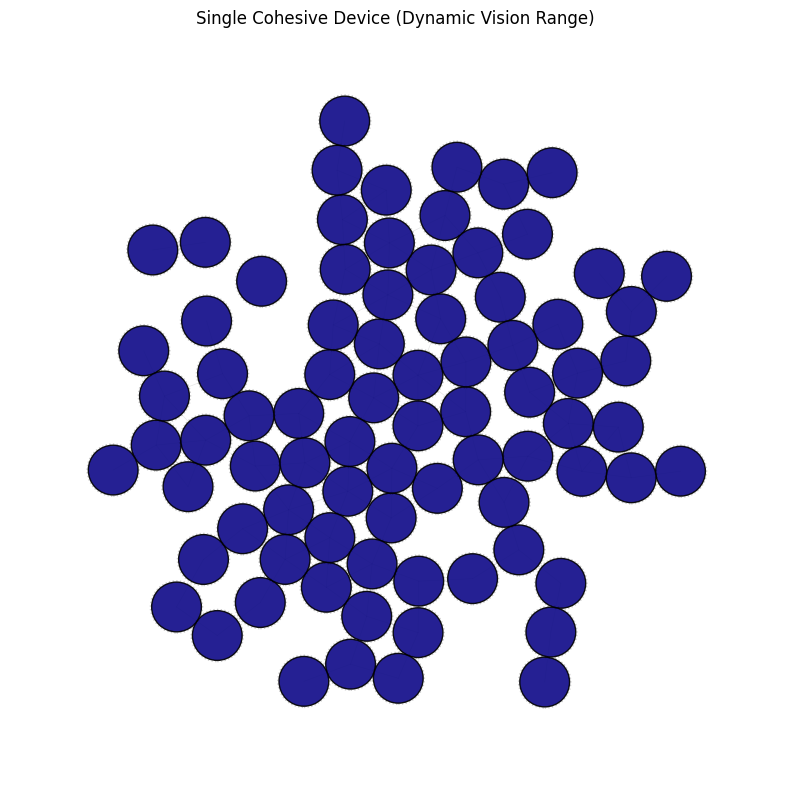

In [ ]:
if __name__ == "__main__":
    N_circles           = 81
    radius_1            = 10.0
    radius_2            = 20.0
    my_radii            = np.full(N_circles, radius_1)
    # idx_large           = np.random.choice(np.arange(N_circles),N_circles//3,replace=False)
    # my_radii[idx_large] = radius_2
    # my_radii            = np.random.uniform(5,20,N_circles)
    my_d_min            = 1.0
    
    packed_result = pack_circles(my_radii, iterations=10000, dt=0.02, k_repel=20.0, k_attract=0.9, max_force=5.0, start_cutoff=50.0, end_cutoff=2.5, safety_passes=1000)
    
    visualize_cluster(my_radii, my_d_min, packed_result)